# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# #Normalisieren der Tensoren
# x_input = norm(x_input, p=1, dim = 1)
# y_output = norm(y_output, p=1, dim = 0)

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-3
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

Epoch 1/200, Iteration 1/12, Loss: 0.0917
Epoch 1/200, Iteration 2/12, Loss: 1.2805
Epoch 1/200, Iteration 3/12, Loss: 2.5397
Epoch 1/200, Iteration 4/12, Loss: 1.9649
Epoch 1/200, Iteration 5/12, Loss: 0.6820
Epoch 1/200, Iteration 6/12, Loss: 0.4852
Epoch 1/200, Iteration 7/12, Loss: 0.6198
Epoch 1/200, Iteration 8/12, Loss: 0.4025
Epoch 1/200, Iteration 9/12, Loss: 0.2659
Epoch 1/200, Iteration 10/12, Loss: 0.2718
Epoch 1/200, Iteration 11/12, Loss: 0.3182
Epoch 1/200, Iteration 12/12, Loss: 0.3126
Epoch 1/200, Iteration 13/12, Loss: 0.2310
Train Error: 
 Accuracy: 56.75%, Avg loss: 0.130119, MRE: 6.724696 

Test Error: 
 Accuracy: 56.5%, Avg loss: 0.136696, MRE: 9.119022 

Epoch 2/200, Iteration 1/12, Loss: 0.1468
Epoch 2/200, Iteration 2/12, Loss: 0.1575
Epoch 2/200, Iteration 3/12, Loss: 0.0942
Epoch 2/200, Iteration 4/12, Loss: 0.1934
Epoch 2/200, Iteration 5/12, Loss: 0.1324
Epoch 2/200, Iteration 6/12, Loss: 0.0898
Epoch 2/200, Iteration 7/12, Loss: 0.0500
Epoch 2/200, Iterati

Train Error: 
 Accuracy: 48.12%, Avg loss: 0.026180, MRE: 1.668306 

Test Error: 
 Accuracy: 47.0%, Avg loss: 0.021948, MRE: 3.668721 

Epoch 14/200, Iteration 1/12, Loss: 0.0254
Epoch 14/200, Iteration 2/12, Loss: 0.0510
Epoch 14/200, Iteration 3/12, Loss: 0.0345
Epoch 14/200, Iteration 4/12, Loss: 0.0701
Epoch 14/200, Iteration 5/12, Loss: 0.0535
Epoch 14/200, Iteration 6/12, Loss: 0.0406
Epoch 14/200, Iteration 7/12, Loss: 0.0417
Epoch 14/200, Iteration 8/12, Loss: 0.0332
Epoch 14/200, Iteration 9/12, Loss: 0.0328
Epoch 14/200, Iteration 10/12, Loss: 0.0368
Epoch 14/200, Iteration 11/12, Loss: 0.0349
Epoch 14/200, Iteration 12/12, Loss: 0.0219
Epoch 14/200, Iteration 13/12, Loss: 0.0309
Train Error: 
 Accuracy: 73.12%, Avg loss: 0.031739, MRE: 1.965899 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.032140, MRE: 2.241847 

Epoch 15/200, Iteration 1/12, Loss: 0.0394
Epoch 15/200, Iteration 2/12, Loss: 0.0331
Epoch 15/200, Iteration 3/12, Loss: 0.0204
Epoch 15/200, Iteration 4/12, Loss: 

Train Error: 
 Accuracy: 77.75%, Avg loss: 0.025875, MRE: 1.398133 

Test Error: 
 Accuracy: 76.0%, Avg loss: 0.023615, MRE: 3.360414 

Epoch 26/200, Iteration 1/12, Loss: 0.0271
Epoch 26/200, Iteration 2/12, Loss: 0.0345
Epoch 26/200, Iteration 3/12, Loss: 0.0207
Epoch 26/200, Iteration 4/12, Loss: 0.0237
Epoch 26/200, Iteration 5/12, Loss: 0.0198
Epoch 26/200, Iteration 6/12, Loss: 0.0228
Epoch 26/200, Iteration 7/12, Loss: 0.0310
Epoch 26/200, Iteration 8/12, Loss: 0.0267
Epoch 26/200, Iteration 9/12, Loss: 0.0292
Epoch 26/200, Iteration 10/12, Loss: 0.0358
Epoch 26/200, Iteration 11/12, Loss: 0.0342
Epoch 26/200, Iteration 12/12, Loss: 0.0317
Epoch 26/200, Iteration 13/12, Loss: 0.0276
Train Error: 
 Accuracy: 91.62%, Avg loss: 0.022337, MRE: 1.383773 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.021600, MRE: 1.921695 

Epoch 27/200, Iteration 1/12, Loss: 0.0222
Epoch 27/200, Iteration 2/12, Loss: 0.0246
Epoch 27/200, Iteration 3/12, Loss: 0.0288
Epoch 27/200, Iteration 4/12, Loss: 

Train Error: 
 Accuracy: 70.12%, Avg loss: 0.027505, MRE: 1.669748 

Test Error: 
 Accuracy: 65.0%, Avg loss: 0.027186, MRE: 1.712671 

Epoch 38/200, Iteration 1/12, Loss: 0.0302
Epoch 38/200, Iteration 2/12, Loss: 0.0228
Epoch 38/200, Iteration 3/12, Loss: 0.0234
Epoch 38/200, Iteration 4/12, Loss: 0.0276
Epoch 38/200, Iteration 5/12, Loss: 0.0297
Epoch 38/200, Iteration 6/12, Loss: 0.0212
Epoch 38/200, Iteration 7/12, Loss: 0.0133
Epoch 38/200, Iteration 8/12, Loss: 0.0205
Epoch 38/200, Iteration 9/12, Loss: 0.0216
Epoch 38/200, Iteration 10/12, Loss: 0.0162
Epoch 38/200, Iteration 11/12, Loss: 0.0335
Epoch 38/200, Iteration 12/12, Loss: 0.0238
Epoch 38/200, Iteration 13/12, Loss: 0.0529
Train Error: 
 Accuracy: 53.0%, Avg loss: 0.015393, MRE: 0.987473 

Test Error: 
 Accuracy: 53.0%, Avg loss: 0.015220, MRE: 0.966178 

Epoch 39/200, Iteration 1/12, Loss: 0.0164
Epoch 39/200, Iteration 2/12, Loss: 0.0127
Epoch 39/200, Iteration 3/12, Loss: 0.0301
Epoch 39/200, Iteration 4/12, Loss: 0

Train Error: 
 Accuracy: 58.38%, Avg loss: 0.009575, MRE: 0.546541 

Test Error: 
 Accuracy: 59.0%, Avg loss: 0.009857, MRE: 0.830851 

Epoch 50/200, Iteration 1/12, Loss: 0.0112
Epoch 50/200, Iteration 2/12, Loss: 0.0110
Epoch 50/200, Iteration 3/12, Loss: 0.0170
Epoch 50/200, Iteration 4/12, Loss: 0.0152
Epoch 50/200, Iteration 5/12, Loss: 0.0151
Epoch 50/200, Iteration 6/12, Loss: 0.0118
Epoch 50/200, Iteration 7/12, Loss: 0.0081
Epoch 50/200, Iteration 8/12, Loss: 0.0082
Epoch 50/200, Iteration 9/12, Loss: 0.0088
Epoch 50/200, Iteration 10/12, Loss: 0.0165
Epoch 50/200, Iteration 11/12, Loss: 0.0212
Epoch 50/200, Iteration 12/12, Loss: 0.0171
Epoch 50/200, Iteration 13/12, Loss: 0.0259
Train Error: 
 Accuracy: 70.88%, Avg loss: 0.008902, MRE: 0.463245 

Test Error: 
 Accuracy: 69.5%, Avg loss: 0.008535, MRE: 1.375878 

Epoch 51/200, Iteration 1/12, Loss: 0.0175
Epoch 51/200, Iteration 2/12, Loss: 0.0083
Epoch 51/200, Iteration 3/12, Loss: 0.0094
Epoch 51/200, Iteration 4/12, Loss: 

Train Error: 
 Accuracy: 87.25%, Avg loss: 0.006969, MRE: 0.355795 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.006641, MRE: 1.256576 

Epoch 62/200, Iteration 1/12, Loss: 0.0112
Epoch 62/200, Iteration 2/12, Loss: 0.0099
Epoch 62/200, Iteration 3/12, Loss: 0.0193
Epoch 62/200, Iteration 4/12, Loss: 0.0062
Epoch 62/200, Iteration 5/12, Loss: 0.0128
Epoch 62/200, Iteration 6/12, Loss: 0.0087
Epoch 62/200, Iteration 7/12, Loss: 0.0096
Epoch 62/200, Iteration 8/12, Loss: 0.0104
Epoch 62/200, Iteration 9/12, Loss: 0.0186
Epoch 62/200, Iteration 10/12, Loss: 0.0063
Epoch 62/200, Iteration 11/12, Loss: 0.0134
Epoch 62/200, Iteration 12/12, Loss: 0.0096
Epoch 62/200, Iteration 13/12, Loss: 0.0073
Train Error: 
 Accuracy: 73.88%, Avg loss: 0.007934, MRE: 0.328726 

Test Error: 
 Accuracy: 72.5%, Avg loss: 0.007725, MRE: 1.088420 

Epoch 63/200, Iteration 1/12, Loss: 0.0298
Epoch 63/200, Iteration 2/12, Loss: 0.0130
Epoch 63/200, Iteration 3/12, Loss: 0.0133
Epoch 63/200, Iteration 4/12, Loss: 

Train Error: 
 Accuracy: 40.25%, Avg loss: 0.015388, MRE: 0.779939 

Test Error: 
 Accuracy: 35.5%, Avg loss: 0.015712, MRE: 1.519138 

Epoch 74/200, Iteration 1/12, Loss: 0.0110
Epoch 74/200, Iteration 2/12, Loss: 0.0159
Epoch 74/200, Iteration 3/12, Loss: 0.0189
Epoch 74/200, Iteration 4/12, Loss: 0.0091
Epoch 74/200, Iteration 5/12, Loss: 0.0139
Epoch 74/200, Iteration 6/12, Loss: 0.0245
Epoch 74/200, Iteration 7/12, Loss: 0.0134
Epoch 74/200, Iteration 8/12, Loss: 0.0250
Epoch 74/200, Iteration 9/12, Loss: 0.0132
Epoch 74/200, Iteration 10/12, Loss: 0.0098
Epoch 74/200, Iteration 11/12, Loss: 0.0083
Epoch 74/200, Iteration 12/12, Loss: 0.0154
Epoch 74/200, Iteration 13/12, Loss: 0.0229
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.018815, MRE: 0.942074 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.021484, MRE: 1.067078 

Epoch 75/200, Iteration 1/12, Loss: 0.0173
Epoch 75/200, Iteration 2/12, Loss: 0.0285
Epoch 75/200, Iteration 3/12, Loss: 0.0139
Epoch 75/200, Iteration 4/12, Loss: 

Train Error: 
 Accuracy: 92.88%, Avg loss: 0.011738, MRE: 1.048150 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.010377, MRE: 1.250449 

Epoch 86/200, Iteration 1/12, Loss: 0.0166
Epoch 86/200, Iteration 2/12, Loss: 0.0156
Epoch 86/200, Iteration 3/12, Loss: 0.0122
Epoch 86/200, Iteration 4/12, Loss: 0.0133
Epoch 86/200, Iteration 5/12, Loss: 0.0158
Epoch 86/200, Iteration 6/12, Loss: 0.0098
Epoch 86/200, Iteration 7/12, Loss: 0.0093
Epoch 86/200, Iteration 8/12, Loss: 0.0207
Epoch 86/200, Iteration 9/12, Loss: 0.0138
Epoch 86/200, Iteration 10/12, Loss: 0.0118
Epoch 86/200, Iteration 11/12, Loss: 0.0124
Epoch 86/200, Iteration 12/12, Loss: 0.0165
Epoch 86/200, Iteration 13/12, Loss: 0.0142
Train Error: 
 Accuracy: 78.75%, Avg loss: 0.009030, MRE: 0.550474 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.008168, MRE: 1.117973 

Epoch 87/200, Iteration 1/12, Loss: 0.0118
Epoch 87/200, Iteration 2/12, Loss: 0.0093
Epoch 87/200, Iteration 3/12, Loss: 0.0207
Epoch 87/200, Iteration 4/12, Loss: 

Train Error: 
 Accuracy: 94.38%, Avg loss: 0.007374, MRE: 0.469037 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.006995, MRE: 1.490733 

Epoch 98/200, Iteration 1/12, Loss: 0.0182
Epoch 98/200, Iteration 2/12, Loss: 0.0116
Epoch 98/200, Iteration 3/12, Loss: 0.0092
Epoch 98/200, Iteration 4/12, Loss: 0.0200
Epoch 98/200, Iteration 5/12, Loss: 0.0073
Epoch 98/200, Iteration 6/12, Loss: 0.0146
Epoch 98/200, Iteration 7/12, Loss: 0.0061
Epoch 98/200, Iteration 8/12, Loss: 0.0092
Epoch 98/200, Iteration 9/12, Loss: 0.0080
Epoch 98/200, Iteration 10/12, Loss: 0.0245
Epoch 98/200, Iteration 11/12, Loss: 0.0076
Epoch 98/200, Iteration 12/12, Loss: 0.0077
Epoch 98/200, Iteration 13/12, Loss: 0.0334
Train Error: 
 Accuracy: 82.12%, Avg loss: 0.006538, MRE: 0.283685 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.006608, MRE: 0.438594 

Epoch 99/200, Iteration 1/12, Loss: 0.0092
Epoch 99/200, Iteration 2/12, Loss: 0.0177
Epoch 99/200, Iteration 3/12, Loss: 0.0152
Epoch 99/200, Iteration 4/12, Loss: 

Train Error: 
 Accuracy: 96.25%, Avg loss: 0.003772, MRE: 0.218564 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003831, MRE: 0.579300 

Epoch 110/200, Iteration 1/12, Loss: 0.0122
Epoch 110/200, Iteration 2/12, Loss: 0.0165
Epoch 110/200, Iteration 3/12, Loss: 0.0115
Epoch 110/200, Iteration 4/12, Loss: 0.0087
Epoch 110/200, Iteration 5/12, Loss: 0.0066
Epoch 110/200, Iteration 6/12, Loss: 0.0092
Epoch 110/200, Iteration 7/12, Loss: 0.0074
Epoch 110/200, Iteration 8/12, Loss: 0.0175
Epoch 110/200, Iteration 9/12, Loss: 0.0097
Epoch 110/200, Iteration 10/12, Loss: 0.0068
Epoch 110/200, Iteration 11/12, Loss: 0.0099
Epoch 110/200, Iteration 12/12, Loss: 0.0113
Epoch 110/200, Iteration 13/12, Loss: 0.0069
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.003743, MRE: 0.215314 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003905, MRE: 0.688304 

Epoch 111/200, Iteration 1/12, Loss: 0.0069
Epoch 111/200, Iteration 2/12, Loss: 0.0148
Epoch 111/200, Iteration 3/12, Loss: 0.0083
Epoch 111/200, Itera

Epoch 121/200, Iteration 12/12, Loss: 0.0159
Epoch 121/200, Iteration 13/12, Loss: 0.0083
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.003879, MRE: 0.223654 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.004106, MRE: 0.480402 

Epoch 122/200, Iteration 1/12, Loss: 0.0071
Epoch 122/200, Iteration 2/12, Loss: 0.0044
Epoch 122/200, Iteration 3/12, Loss: 0.0054
Epoch 122/200, Iteration 4/12, Loss: 0.0064
Epoch 122/200, Iteration 5/12, Loss: 0.0089
Epoch 122/200, Iteration 6/12, Loss: 0.0118
Epoch 122/200, Iteration 7/12, Loss: 0.0132
Epoch 122/200, Iteration 8/12, Loss: 0.0068
Epoch 122/200, Iteration 9/12, Loss: 0.0207
Epoch 122/200, Iteration 10/12, Loss: 0.0229
Epoch 122/200, Iteration 11/12, Loss: 0.0142
Epoch 122/200, Iteration 12/12, Loss: 0.0068
Epoch 122/200, Iteration 13/12, Loss: 0.0140
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.003777, MRE: 0.287115 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.004294, MRE: 0.681300 

Epoch 123/200, Iteration 1/12, Loss: 0.0061
Epoch 123/200, Iter

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.003430, MRE: 0.239534 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003997, MRE: 0.568890 

Epoch 134/200, Iteration 1/12, Loss: 0.0082
Epoch 134/200, Iteration 2/12, Loss: 0.0066
Epoch 134/200, Iteration 3/12, Loss: 0.0098
Epoch 134/200, Iteration 4/12, Loss: 0.0066
Epoch 134/200, Iteration 5/12, Loss: 0.0154
Epoch 134/200, Iteration 6/12, Loss: 0.0110
Epoch 134/200, Iteration 7/12, Loss: 0.0233
Epoch 134/200, Iteration 8/12, Loss: 0.0048
Epoch 134/200, Iteration 9/12, Loss: 0.0087
Epoch 134/200, Iteration 10/12, Loss: 0.0099
Epoch 134/200, Iteration 11/12, Loss: 0.0110
Epoch 134/200, Iteration 12/12, Loss: 0.0062
Epoch 134/200, Iteration 13/12, Loss: 0.0062
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.003407, MRE: 0.254363 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003898, MRE: 0.537953 

Epoch 135/200, Iteration 1/12, Loss: 0.0069
Epoch 135/200, Iteration 2/12, Loss: 0.0095
Epoch 135/200, Iteration 3/12, Loss: 0.0096
Epoch 135/200, Itera

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.003366, MRE: 0.228531 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003865, MRE: 0.612580 

Epoch 146/200, Iteration 1/12, Loss: 0.0061
Epoch 146/200, Iteration 2/12, Loss: 0.0143
Epoch 146/200, Iteration 3/12, Loss: 0.0067
Epoch 146/200, Iteration 4/12, Loss: 0.0102
Epoch 146/200, Iteration 5/12, Loss: 0.0097
Epoch 146/200, Iteration 6/12, Loss: 0.0071
Epoch 146/200, Iteration 7/12, Loss: 0.0094
Epoch 146/200, Iteration 8/12, Loss: 0.0059
Epoch 146/200, Iteration 9/12, Loss: 0.0074
Epoch 146/200, Iteration 10/12, Loss: 0.0060
Epoch 146/200, Iteration 11/12, Loss: 0.0140
Epoch 146/200, Iteration 12/12, Loss: 0.0073
Epoch 146/200, Iteration 13/12, Loss: 0.0050
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.003446, MRE: 0.214470 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003805, MRE: 0.485136 

Epoch 147/200, Iteration 1/12, Loss: 0.0134
Epoch 147/200, Iteration 2/12, Loss: 0.0144
Epoch 147/200, Iteration 3/12, Loss: 0.0074
Epoch 147/200, Itera

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.003440, MRE: 0.212243 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.004017, MRE: 0.583764 

Epoch 158/200, Iteration 1/12, Loss: 0.0058
Epoch 158/200, Iteration 2/12, Loss: 0.0094
Epoch 158/200, Iteration 3/12, Loss: 0.0135
Epoch 158/200, Iteration 4/12, Loss: 0.0059
Epoch 158/200, Iteration 5/12, Loss: 0.0160
Epoch 158/200, Iteration 6/12, Loss: 0.0086
Epoch 158/200, Iteration 7/12, Loss: 0.0135
Epoch 158/200, Iteration 8/12, Loss: 0.0056
Epoch 158/200, Iteration 9/12, Loss: 0.0056
Epoch 158/200, Iteration 10/12, Loss: 0.0065
Epoch 158/200, Iteration 11/12, Loss: 0.0103
Epoch 158/200, Iteration 12/12, Loss: 0.0080
Epoch 158/200, Iteration 13/12, Loss: 0.0221
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.003658, MRE: 0.212806 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.003734, MRE: 0.572805 

Epoch 159/200, Iteration 1/12, Loss: 0.0110
Epoch 159/200, Iteration 2/12, Loss: 0.0098
Epoch 159/200, Iteration 3/12, Loss: 0.0058
Epoch 159/200, Itera

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.003438, MRE: 0.222937 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.004001, MRE: 0.541193 

Epoch 170/200, Iteration 1/12, Loss: 0.0047
Epoch 170/200, Iteration 2/12, Loss: 0.0041
Epoch 170/200, Iteration 3/12, Loss: 0.0094
Epoch 170/200, Iteration 4/12, Loss: 0.0127
Epoch 170/200, Iteration 5/12, Loss: 0.0052
Epoch 170/200, Iteration 6/12, Loss: 0.0052
Epoch 170/200, Iteration 7/12, Loss: 0.0098
Epoch 170/200, Iteration 8/12, Loss: 0.0066
Epoch 170/200, Iteration 9/12, Loss: 0.0125
Epoch 170/200, Iteration 10/12, Loss: 0.0148
Epoch 170/200, Iteration 11/12, Loss: 0.0074
Epoch 170/200, Iteration 12/12, Loss: 0.0089
Epoch 170/200, Iteration 13/12, Loss: 0.0065
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.003434, MRE: 0.208242 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003913, MRE: 0.527113 

Epoch 171/200, Iteration 1/12, Loss: 0.0097
Epoch 171/200, Iteration 2/12, Loss: 0.0263
Epoch 171/200, Iteration 3/12, Loss: 0.0083
Epoch 171/200, Iterati

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.003446, MRE: 0.228829 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.004179, MRE: 0.563879 

Epoch 182/200, Iteration 1/12, Loss: 0.0092
Epoch 182/200, Iteration 2/12, Loss: 0.0080
Epoch 182/200, Iteration 3/12, Loss: 0.0157
Epoch 182/200, Iteration 4/12, Loss: 0.0054
Epoch 182/200, Iteration 5/12, Loss: 0.0093
Epoch 182/200, Iteration 6/12, Loss: 0.0055
Epoch 182/200, Iteration 7/12, Loss: 0.0060
Epoch 182/200, Iteration 8/12, Loss: 0.0186
Epoch 182/200, Iteration 9/12, Loss: 0.0073
Epoch 182/200, Iteration 10/12, Loss: 0.0061
Epoch 182/200, Iteration 11/12, Loss: 0.0136
Epoch 182/200, Iteration 12/12, Loss: 0.0056
Epoch 182/200, Iteration 13/12, Loss: 0.0172
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.003381, MRE: 0.215596 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003972, MRE: 0.630386 

Epoch 183/200, Iteration 1/12, Loss: 0.0119
Epoch 183/200, Iteration 2/12, Loss: 0.0186
Epoch 183/200, Iteration 3/12, Loss: 0.0110
Epoch 183/200, Iterat

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.003533, MRE: 0.208261 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.003800, MRE: 0.546110 

Epoch 194/200, Iteration 1/12, Loss: 0.0088
Epoch 194/200, Iteration 2/12, Loss: 0.0040
Epoch 194/200, Iteration 3/12, Loss: 0.0151
Epoch 194/200, Iteration 4/12, Loss: 0.0058
Epoch 194/200, Iteration 5/12, Loss: 0.0081
Epoch 194/200, Iteration 6/12, Loss: 0.0072
Epoch 194/200, Iteration 7/12, Loss: 0.0045
Epoch 194/200, Iteration 8/12, Loss: 0.0071
Epoch 194/200, Iteration 9/12, Loss: 0.0085
Epoch 194/200, Iteration 10/12, Loss: 0.0201
Epoch 194/200, Iteration 11/12, Loss: 0.0112
Epoch 194/200, Iteration 12/12, Loss: 0.0114
Epoch 194/200, Iteration 13/12, Loss: 0.0335
Train Error: 
 Accuracy: 95.25%, Avg loss: 0.004088, MRE: 0.215111 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.004131, MRE: 0.519461 

Epoch 195/200, Iteration 1/12, Loss: 0.0109
Epoch 195/200, Iteration 2/12, Loss: 0.0200
Epoch 195/200, Iteration 3/12, Loss: 0.0257
Epoch 195/200, Iterat

#### Plots loss vs Epoch

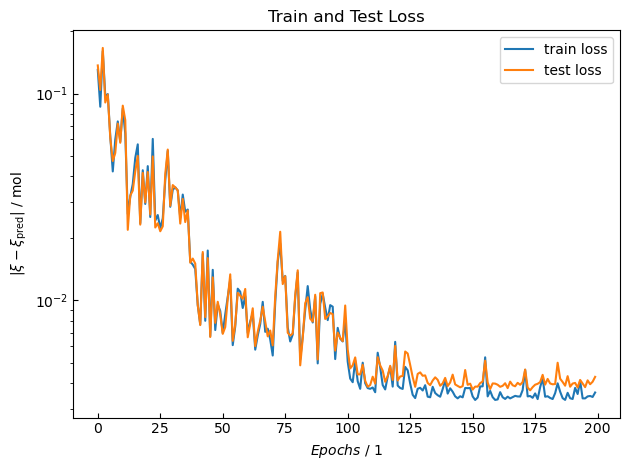

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = 0.9847481039439929
Test Dataset: R^2 = 0.9706980559286598
Max Error Training: |xi - xi_pred| = 0.048421630817001154
Max Error Test: |xi - xi_pred| = 0.06435028311242602


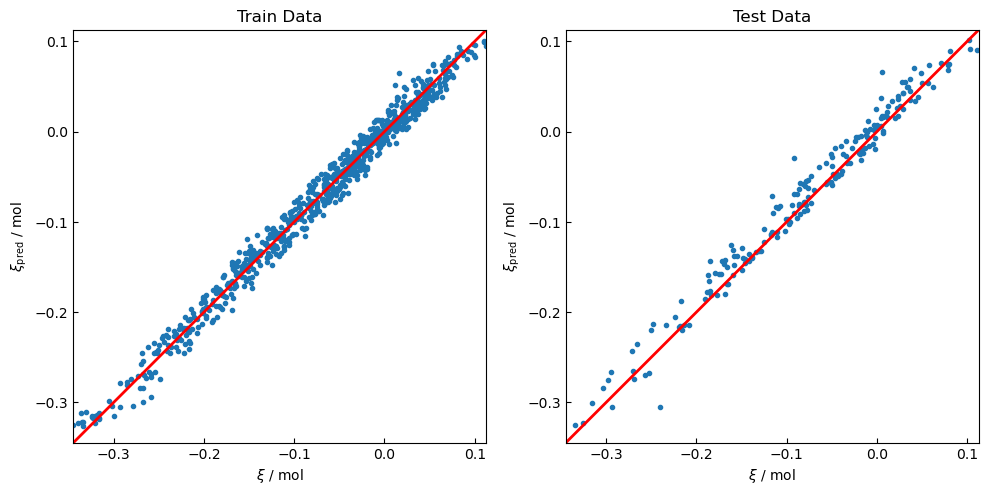

In [11]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))
print('Max Error Training: |xi - xi_pred| =', max_error(xi_real, xi_pred))
print('Max Error Test: |xi - xi_pred| =', max_error(xi_real_test, xi_pred_test))

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

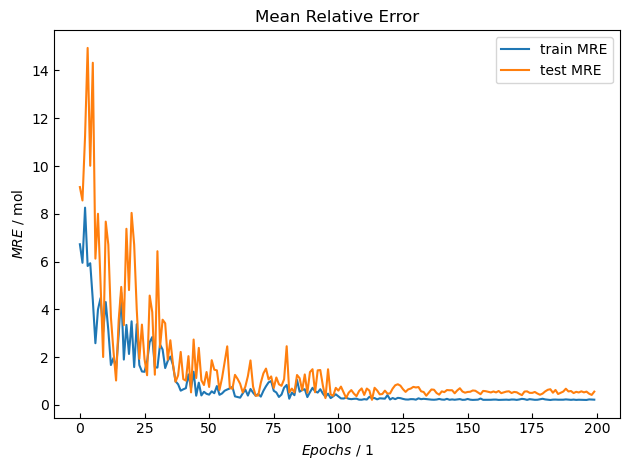

In [12]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

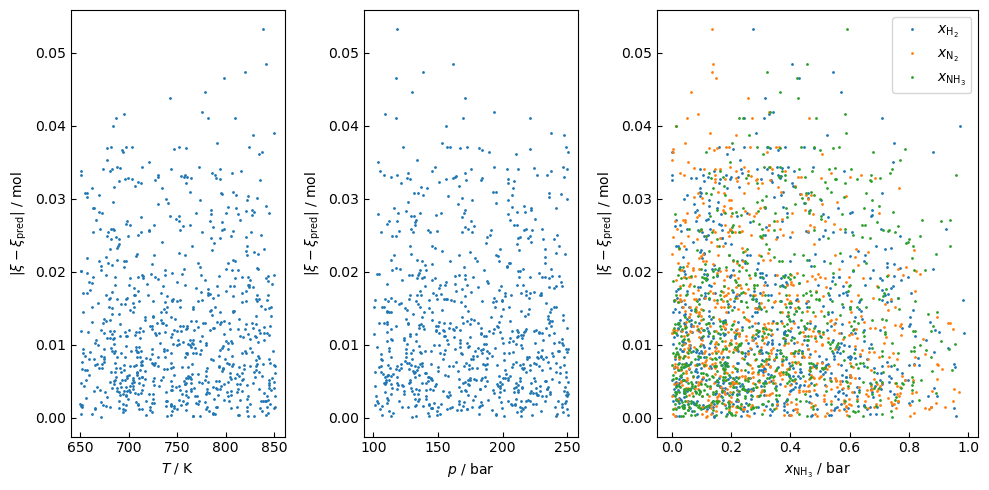

In [13]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

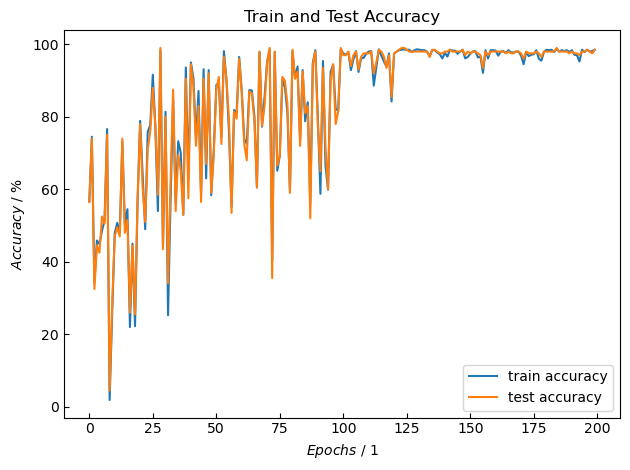

In [14]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [15]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[8.0184e+02, 2.0696e+02, 3.7439e-01, 3.1179e-01, 3.1383e-01],
        [7.5555e+02, 2.3286e+02, 5.3796e-02, 5.1268e-01, 4.3353e-01],
        [7.3881e+02, 1.3559e+02, 4.3281e-02, 7.5411e-01, 2.0261e-01],
        [6.5193e+02, 2.0982e+02, 1.7914e-01, 4.8336e-01, 3.3749e-01],
        [8.0787e+02, 1.1347e+02, 5.4088e-01, 9.2709e-02, 3.6641e-01],
        [7.5218e+02, 1.3146e+02, 6.7328e-01, 1.9960e-01, 1.2712e-01],
        [7.2624e+02, 2.0181e+02, 6.3072e-01, 4.9557e-02, 3.1972e-01],
        [8.2076e+02, 2.1313e+02, 3.9966e-01, 2.9996e-01, 3.0038e-01],
        [7.5787e+02, 1.4859e+02, 4.0315e-01, 4.8545e-01, 1.1139e-01],
        [7.8489e+02, 1.2609e+02, 6.5320e-02, 7.3103e-01, 2.0365e-01],
        [6.7654e+02, 1.4855e+02, 5.9135e-01, 3.9499e-01, 1.3655e-02],
        [8.2527e+02, 2.2769e+02, 4.7819e-01, 3.3074e-01, 1.9107e-01],
        [8.0498e+02, 2.2130e+02, 7.6967e-01, 1.1676e-01, 1.1357e-01],
        [8.1394e+02, 1.7550e+02, 1.3122e-01, 1.5819e-01, 7.1058e-01],
        [7.9931e+02,

#### Einblick in Netzwerk

In [16]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.7862, 0.8008, 0.9055, 0.8892, 0.9005], requires_grad=True),
 Parameter containing:
 tensor([-0.0539, -0.0188, -0.0564,  0.0219,  0.0010], requires_grad=True),
 Parameter containing:
 tensor([[ 1.0759e-01, -6.9253e-03,  3.0391e-01, -5.8297e-02,  2.9266e-01],
         [ 1.6616e-01,  4.7319e-01, -3.4196e-01,  3.4473e-01, -2.4297e-01],
         [-2.4489e-01,  4.8724e-02,  1.0354e-01, -2.6553e-01, -3.8790e-01],
         [-1.6014e-01,  1.0493e-01,  9.7259e-02, -3.6144e-01,  3.7232e-01],
         [-2.1305e-01,  1.6956e-01, -3.0158e-01,  2.2725e-02, -3.0833e-01],
         [-2.6563e-01,  6.3236e-02, -2.2697e-01, -1.1753e-01,  2.4098e-01],
         [-1.5366e-01, -2.0880e-02, -9.2415e-02, -3.3859e-01, -3.0378e-01],
         [-2.0958e-01,  2.5512e-02, -3.0271e-01,  2.6056e-01, -2.3789e-01],
         [ 3.0930e-01, -1.7240e-01,  1.7122e-01, -2.1928e-01,  1.1575e-01],
         [ 3.4791e-01, -1.2314e-02, -3.4743e-01,  1.2821e-01,  3.1804e-01],
         [-7.0256e-04, -

In [17]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1657, 0.5728, 0.6980, 0.3134, 0.3501],
        [0.2312, 0.1870, 0.5855, 0.5876, 0.3957]])
tensor([[ 0.0772],
        [-0.1609]], grad_fn=<AddmmBackward0>)


In [18]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [19]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[7.0712e+02, 1.6681e+02, 1.0791e-01, 7.5264e-02, 8.1683e-01],
        [8.4633e+02, 2.0111e+02, 1.9034e-02, 1.6956e-01, 8.1141e-01],
        [7.8441e+02, 2.2223e+02, 8.4636e-02, 4.4983e-01, 4.6553e-01],
        [6.9682e+02, 1.1063e+02, 1.5887e-01, 5.4630e-01, 2.9483e-01],
        [7.1356e+02, 2.1330e+02, 1.8109e-01, 8.1885e-01, 6.2500e-05],
        [8.3747e+02, 1.8942e+02, 1.3452e-03, 3.2090e-01, 6.7776e-01],
        [7.0795e+02, 1.9600e+02, 6.0031e-01, 9.8111e-02, 3.0158e-01],
        [6.6866e+02, 2.1414e+02, 1.0400e-01, 5.8350e-02, 8.3765e-01],
        [7.5218e+02, 1.3146e+02, 6.7328e-01, 1.9960e-01, 1.2712e-01],
        [7.6411e+02, 1.7743e+02, 1.0189e-01, 8.9479e-01, 3.3184e-03],
        [7.2149e+02, 1.1730e+02, 2.6886e-01, 1.2726e-01, 6.0387e-01],
        [7.3278e+02, 2.2101e+02, 5.7912e-01, 1.8778e-01, 2.3310e-01],
        [7.5918e+02, 1.8176e+02, 3.3022e-01, 1.2455e-01, 5.4523e-01],
        [7.3970e+02, 2.0141e+02, 1.1158e-01, 1.7636e-01, 7.1206e-01],
        [7.5919e+02,

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()